Ömer Gözüaçık, 29/05/2020

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from scipy.optimize import minimize

import warnings 
warnings.filterwarnings('ignore')

## Importing data

In [2]:
pd.set_option('display.max_columns',None)

# training data
train = pd.read_csv('train.csv')

# test data
test = pd.read_csv('test.csv')
df=pd.concat([train,test], sort=False)
train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46

### Converting categorical feature to numbers

There is no specific reason. I think it is easier for the eye.

In [3]:
df["galaxy"] = df["galaxy"].astype('category')
df["galaxy"] = df["galaxy"].cat.codes
train = df[:3865]
test = df[3865:]
test=test.drop("y", axis = 1)
test_res= test.copy()

### Checking how many galaxies are there and how many of them are distinct.

- There are **181** distinct galaxies on the training set and **172** on the test set.

- On overall they each galaxy has **20** samples on the training set and **5** on the test set.

- **Some galaxies on the training set does not exist on the test set.**

- **Galaxy 126** has only one sample. I discard it on the training phase

As far as I know, the world bank has **182** members (countries) in 2000s (IBRD). Each distinct galaxy may represent a country in real life. Every sample for a galaxy may represent the properties of the country at a time (galactic year). 

In [4]:
train_gal=set(train["galaxy"])
s=0
for x in train_gal:
    s=s+len(train.loc[train['galaxy'] == x])
print("Total distinct galaxies: {}".format(len(train_gal)))
print("Average samples per galaxy: {}".format(s/len(train_gal)))

Total distinct galaxies: 181
Average samples per galaxy: 21.353591160220994


,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,96,0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46.018230,98.216072,174.6178

In [5]:
test_gal=set(test["galaxy"])
s=0
for x in test_gal:
    s=s+len(test.loc[test['galaxy'] == x])
print("Total distinct galaxies: {}".format(len(test_gal)))
print("Average samples per galaxy: {}".format(s/len(test_gal)))

Total distinct galaxies: 172
Average samples per galaxy: 5.174418604651163


#### Number of samples and features
Train set: 3865

Test set: 890

Features: 79

In [6]:
print("Train vector: " + str(train.shape))
print("Test vector: " + str(test.shape))

Train vector: (3865, 80)
Test vector: (890, 79)


## Methods for Cross-validating Training Data

- I trained **a model for exery distinct galaxy** in the training set (180) except the one from 126th galaxy as it has only one sample. 

- I used **features with top x correlation** with respect to y (target variable) galaxy specific. (x is found by trying different values [20,25,30,40,50,60,70])

- Missing values are filled with the galaxy specific 'mean' of the data. (Median can be used alternatively.)

- **Train and test sets are not mixed for both imputation and standardization.**

- Standard Scaler is used to standardize data.

- Gradient Boosted Regression is used as a model.

In [7]:
def cross_validation_loop(data,cor):
    labels= data['y']
    data=data.drop('galaxy', axis=1)    
    data=data.drop('y', axis=1)
    
    correlation=abs(data.corrwith(labels))
    columns=correlation.nlargest(cor).index
    data=data[columns]
    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(data)
    data=imp.transform(data)

    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)
        
    estimator = GradientBoostingRegressor(n_estimators=300)
    
    cv_results = cross_validate(estimator, data, labels, cv=4, scoring='neg_root_mean_squared_error')

    error=np.mean(cv_results['test_score'])
    
    return error

#### Code for cross-validating a model for every galaxy

I return the mean of the cross-validation scores disregarding the differences of their sample sizes.

In [8]:
train_gal=set(train["galaxy"])
train_gal.remove(126)
def loop_train(cor):
    errors=[]
    for gal in train_gal:
        index = train.index[train['galaxy'] == gal]
        data = train.loc[index]
        errors.append(cross_validation_loop(data,cor))
    return np.mean(errors)

#### Checking which correlation threshold gives better value

The model performs best when the threshold is 20 with RMSE of 0.0063

In [9]:
cor=[20,25,30,40,50,60,70,80]
errors=[]
for x in cor:
    errors.append(loop_train(x))

In [10]:
print(errors)

[-0.006349295024523504, -0.006355013429035208, -0.0064544926989322385, -0.006635855916937299, -0.006766983664874868, -0.00694985406472172, -0.006971376359082463, -0.007007182131967394]


## Making predictions on the test data

- Similar methodology is used to fill the missing value and standardization.
- The best covariance threshold in the cross validation, 20, is used.

In [11]:
def test_loop(data, test_data):
    labels= data['y']
    data=data.drop('galaxy', axis=1)    
    data=data.drop('y', axis=1)
    correlation=abs(data.corrwith(labels))
    columns=correlation.nlargest(20).index
    
    train_labels= labels
    train_data=data[columns]
    test_data= test_data[columns]
    
    imp = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train_data)
    train_data=imp.transform(train_data)
    test_data=imp.transform(test_data)

    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    model = GradientBoostingRegressor(n_estimators=300)
    model.fit(train_data, train_labels)

    predictions = model.predict(test_data)
    return predictions

#### Sorting samples with respect to their unique galaxy type. 

In [12]:
test=test_res
test=test.sort_values(by=['galaxy'])
test_pred = pd.DataFrame(0, index=np.arange(len(test)), columns=["predicted_y"])

#### Looping over all galaxy types in the test set and making predictions.

In [13]:
i=0
for gal in test_gal:
    count=len(test.loc[test['galaxy'] == gal])
    index = train.index[train['galaxy'] == gal]
    data = train.loc[index]
    pred=test_loop(data,test.loc[test['galaxy']==gal])
    test_pred.loc[i:i+count-1,'predicted_y'] = pred
    i=i+count 

#### Sorting samples with respect to the index.

In [14]:
test["predicted_y"]=test_pred.to_numpy()
test.sort_index(inplace=True)
predictions = test["predicted_y"]

## Discussion 1

- With this approach, we are **not using 8 galaxies in the training set as they are not in the test set.** (Almost 160 samples)

- A better approach should use them as well.

- According to our theory, every galaxy represent a country and samples are its properties at a time (maybe galactic year represents time).

- Some countries may have missing values as they may have joined IBRD late. This may be organizers decision as well. Filling missing values with regression can improve performance.

- World Bank categorizes countries by both region and income: https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

7 regions: East Asia and Pacific, Europe and Central Asia, Latin America & the Caribbean, Middle East and North Africa, North America, South Asia, Sub-Saharan Africa

4 income groups: Low-income economies, Lower-middle-income economies, Upper-middle-income economies, High-income economies 

- Clustering galaxies may excel the performance of the model. I would try both clustering galaxies to either 4 or 7 clusters. Then try making imputation/training with respect to every cluster.

This code is a summary of what we have done. We also analyzed RMSE for cross-validation for per galaxy. 

Galaxies: {128, 2, 4, 5, 133, 11, 140, 147, 153, 154, 34, 35, 40, 43, 55, 64, 76, 78, 83, 100, 101, 102, 107, 108, 119} have RMSE over 0.008. 

The list gives them in order, 128th having 0.008559 and 119th having 0.034926. 

- Fine tuning these problematic galaxies with low cross-validation scores can excel the performance of the model

## Optimization part

- Ideally giving 100 to top 500 samples with highest p^2 values should optimize the likely increase.
- However, as the predictions can be faulty, this approach would result with lower Leaderboard Score.

E.g: If the original p^2 value is higher than the predicted p^2, it will increase the error as we are directly giving it 0.

- That's why, I believe its better to spread the risk for the samples in the bordering regions (400< [rank of p^2] <600).
- I assign 100 energy to top 400 samples and 50 energy to the remaining top 200 samples.

(array([663.,  94.,  57.,  38.,  28.,   5.,   3.,   0.,   0.,   2.]),
 array([0.02208662, 0.08435184, 0.14661706, 0.20888229, 0.27114751,
        0.33341274, 0.39567796, 0.45794318, 0.52020841, 0.58247363,
        0.64473885]),
 <a list of 10 Patch objects>)

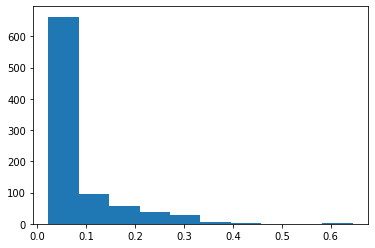

In [16]:
import matplotlib.pyplot as plt
plt.hist(predictions)

In [17]:
index = predictions
pot_inc = -np.log(index+0.01)+3

In [18]:
p2= pot_inc**2

In [19]:
ss = pd.DataFrame({
    'Index':test.index,
    'pred': predictions,
    'opt_pred':0,
    'eei':test['existence expectancy index'], # So we can split into low and high EEI galaxies
})

In [20]:
ss.loc[p2.nlargest(400).index, 'opt_pred']=100
ss=ss.sort_values('pred')
ss.iloc[400:600].opt_pred = 50
ss=ss.sort_index()

In [21]:
increase = (ss['opt_pred']*p2)/1000

In [22]:
print(sum(increase), ss.loc[ss.eei < 0.7, 'opt_pred'].sum(), ss['opt_pred'].sum())

1789.0419385273092 6500 50000


In [33]:
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)

## Discussion 2

- Optimization can be done better by changing the spreading the risk part (assigning energy to the 400<p^2<600 region).

- You can give values that are decreasing starting from 400th to 600th (99, 98, 97...). 

It is less likely for the 400th sample to be out of top 500, and similarly it is less likely for the 600th sample to be in the top 500. That's why, you can give more energy to the ones in the 400-500 region and less to the 500-600.

- This approach got me and my friend to the best score of 0.04271993 which is ranked 22nd right now.

- As we are out of top 20 and reached the upload limit, we are sharing our approach publicly to help other teams that have worse results. 
